2025-07-23 07:41:10.239990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753256470.544587      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753256470.634667      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-23 07:41:29.384262: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

 LSTM Performance:
RMSE: 0.0899
R²:   0.8918


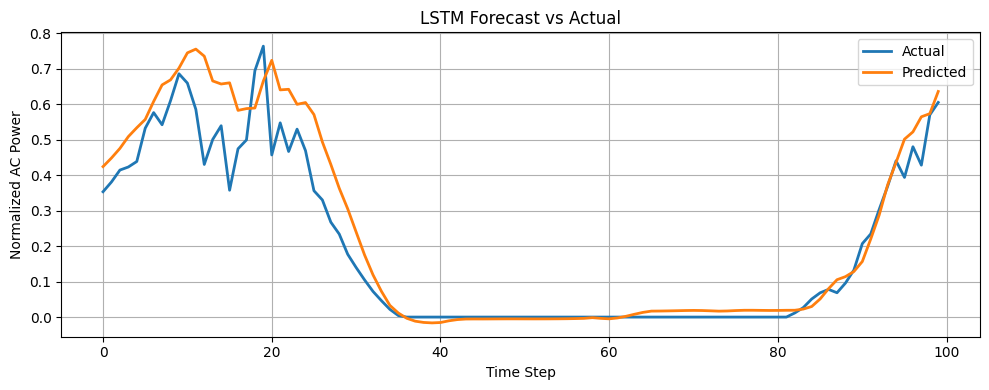

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step

 BiLSTM Performance:
RMSE: 0.0835
R²:   0.9067


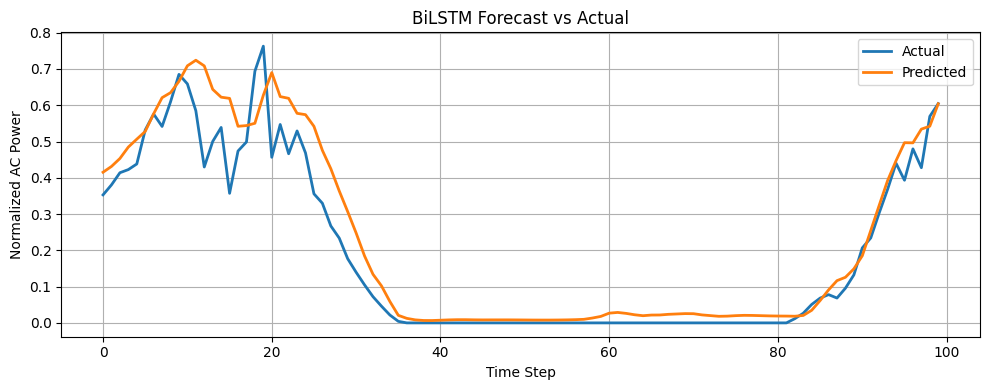

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step

 BiGRU Performance:
RMSE: 0.0722
R²:   0.9303


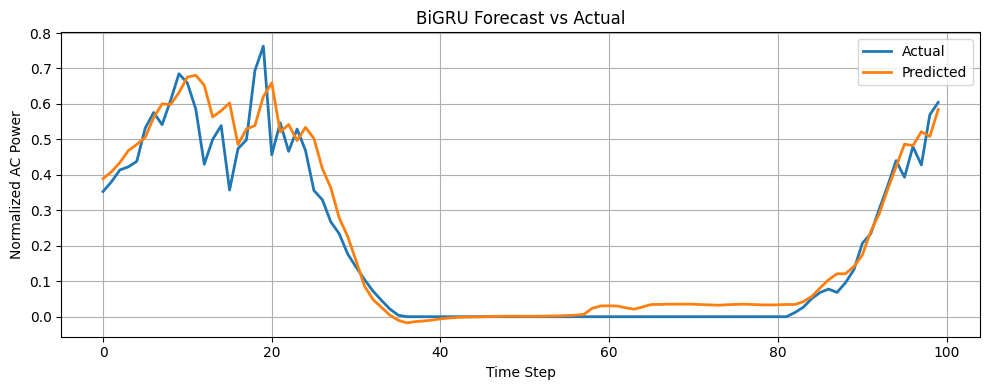

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

 BiRNN Performance:
RMSE: 0.0743
R²:   0.9261


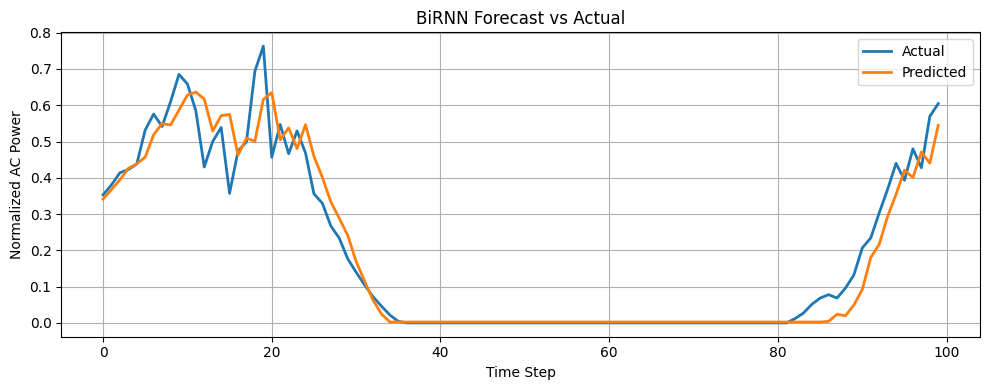

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

gen_df = pd.read_csv("/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv")
weather_df = pd.read_csv("/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv")

gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'], format='%d-%m-%Y %H:%M')
weather_df['DATE_TIME'] = pd.to_datetime(weather_df['DATE_TIME'])

gen_agg = gen_df.groupby('DATE_TIME').agg({
    'DC_POWER': 'sum',
    'AC_POWER': 'sum',
    'DAILY_YIELD': 'mean',
    'TOTAL_YIELD': 'mean'
}).reset_index()

merged_df = pd.merge(gen_agg, weather_df[['DATE_TIME', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']],
                     on='DATE_TIME', how='inner')
merged_df = merged_df.sort_values('DATE_TIME')

features = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
            'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']
target_col = 'AC_POWER'

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_df[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)

LB, LA = 8, 1
X, y = [], []
for i in range(len(scaled_df) - LB - LA + 1):
    X.append(scaled_df[features].iloc[i:i+LB].values)
    y.append(scaled_df[target_col].iloc[i+LB+LA-1])
X = np.array(X)
y = np.array(y)

n = len(X)
n_train = int(0.7 * n)
n_val = int(0.1 * n)
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

def build_model(model_type='LSTM', input_shape=(8, 7)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if model_type == 'LSTM':
        model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(LSTM(32, kernel_regularizer=l2(0.001)))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.001))))
    elif model_type == 'BiGRU':
        model.add(Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=l2(0.001))))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Bidirectional(GRU(32, kernel_regularizer=l2(0.001))))
    elif model_type == 'BiRNN':
        model.add(Bidirectional(SimpleRNN(64, return_sequences=True, kernel_regularizer=l2(0.001))))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Bidirectional(SimpleRNN(32, kernel_regularizer=l2(0.001))))
    else:
        raise ValueError("Unsupported model type")
  
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # Output
    model.compile(optimizer='adam', loss='mse')
    return model

def train_and_evaluate(model_type):
    model = build_model(model_type)
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=0)  
    
    y_pred = model.predict(X_test).flatten()
    y_true = y_test

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n {model_type} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    plt.figure(figsize=(10, 4))
    plt.plot(y_true[:100], label='Actual', linewidth=2)
    plt.plot(y_pred[:100], label='Predicted', linewidth=2)
    plt.title(f'{model_type} Forecast vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized AC Power')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for model_type in ['LSTM', 'BiLSTM', 'BiGRU', 'BiRNN']:
    train_and_evaluate(model_type)
